In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import wfsc_tests as wfsc
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

from wfsc_tests.math_module import xp, _scipy

import cgi_phasec_poppy as cgi
reload(cgi)

import ray

wavelength_c = 575e-9*u.m
iwa = 2.8
owa = 9.7

nlam = 3
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

data_dir = cgi.data_dir

dm1_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:
reload(cgi)
rayCGI = ray.remote(cgi.CGI)

mode_settings = {
    'cgi_mode':'hlc',
    'use_pupil_defocus':True, 
    'use_opds':True,
}

actors = []
for i in range(nlam):
    actors.append(rayCGI.options(num_gpus=1/nlam).remote(wavelength=wavelengths[i], **mode_settings))


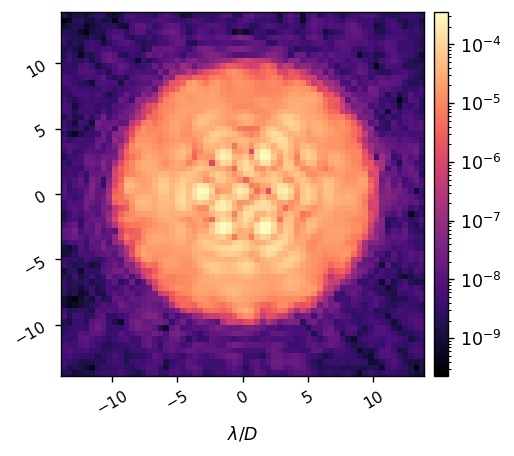

In [3]:
c = cgi.BBCGI(actors)
c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

npsf = c.npsf
Nact = c.Nact

c.use_fpm(False)
ref_unocc_im = c.snap()
wfsc.imshow1(ref_unocc_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

c.use_fpm(True)
ref_im = c.snap()/max_ref
wfsc.imshow1(ref_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

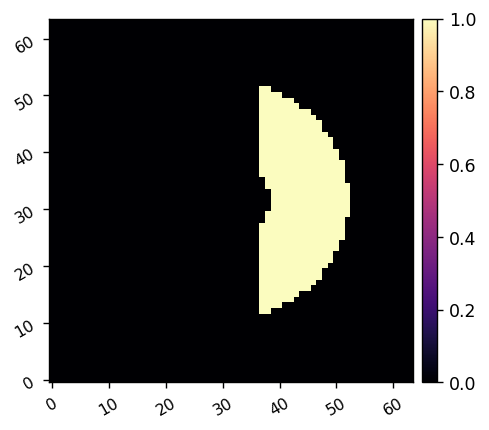

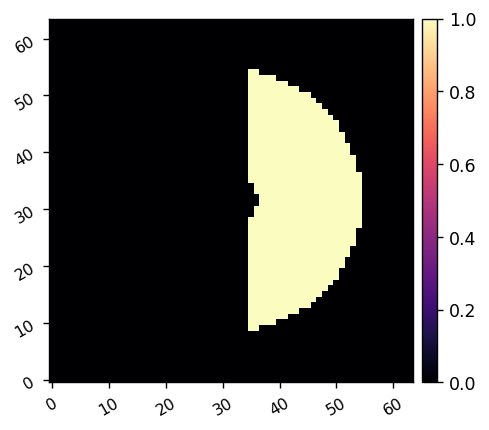

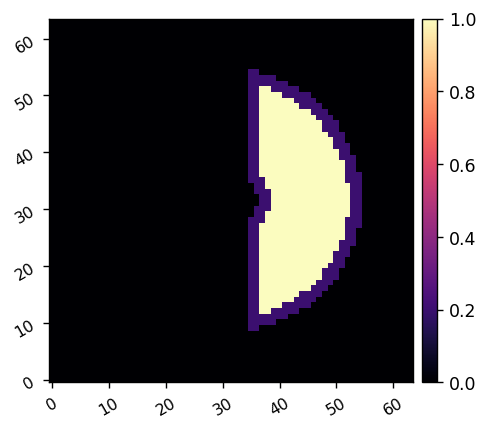

In [52]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = (3-1)
owa = (9+1)
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 1.5,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

# wfsc.imshow2(roi1, roi2)
weight_map = roi1 + 0.2*(roi2 * ~roi1)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

probe_amp = 3e-8
calib_amp = 5e-9

(344, 2304) (172, 2)


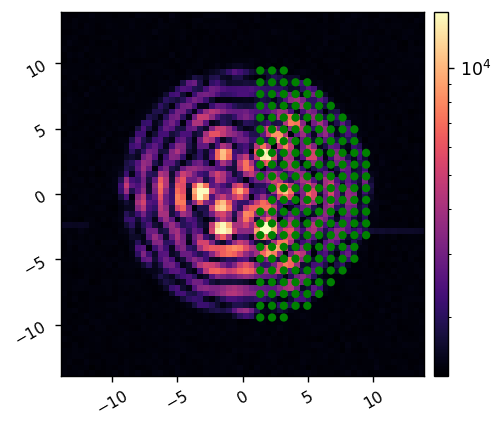

In [8]:
reload(wfsc.utils)
calib_amp = 5e-9
fourier_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask, fourier_sampling=0.9) 
nmodes = fourier_modes.shape[0]
print(fourier_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
wfsc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD, patches=patches)

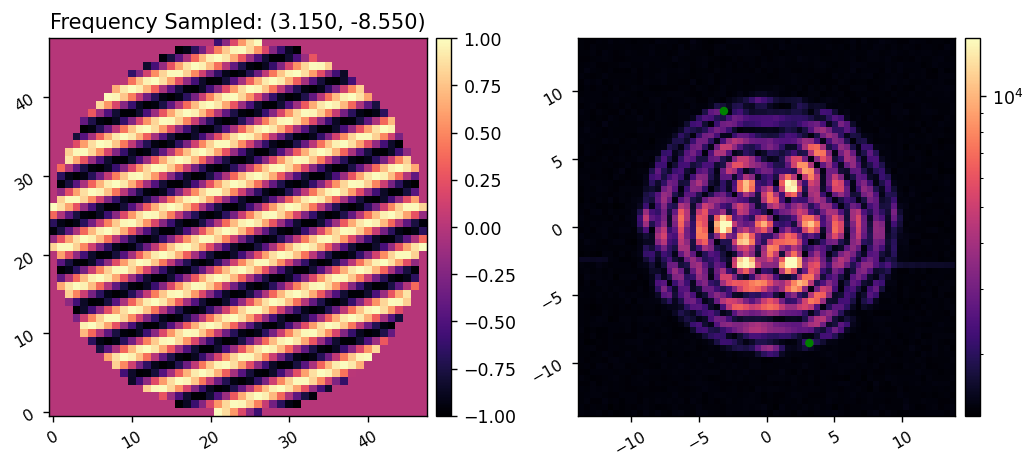

In [11]:
for i in range(fourier_modes.shape[0]//2):
    try:
        wfsc.imshow2(fourier_modes[i].reshape(Nact,Nact), ref_im, 
                       'Frequency Sampled: ({:.3f}, {:.3f})'.format(fs[i][0], fs[i][1]),
                       lognorm2=True,
                       pxscl2=c.psf_pixelscale_lamD, 
                       patches2=[Circle(fs[i], 0.25, fill=True, color='g'),
                                 Circle(-fs[i], 0.25, fill=True, color='g')])
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

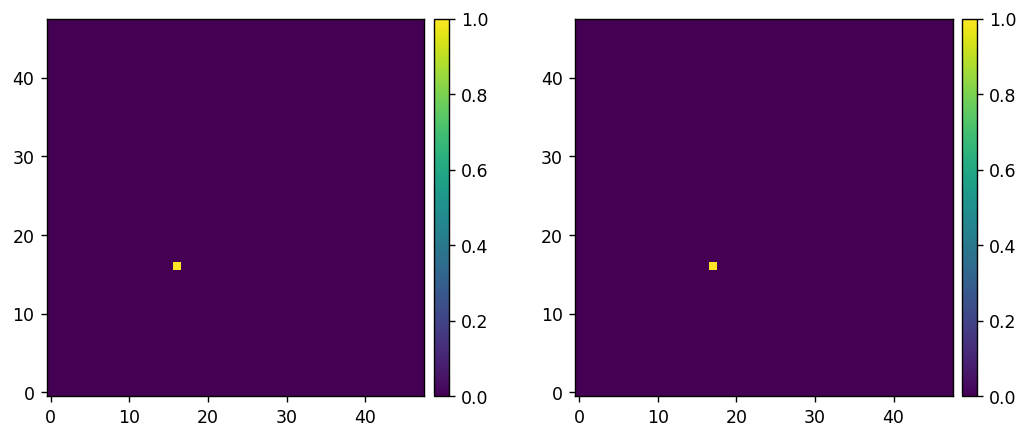

In [12]:
reload(wfsc.utils)
probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
                                                 poke_indices=[(Nact//3, Nact//3), (Nact//3+1, Nact//3)], 
                                                 plot=True)

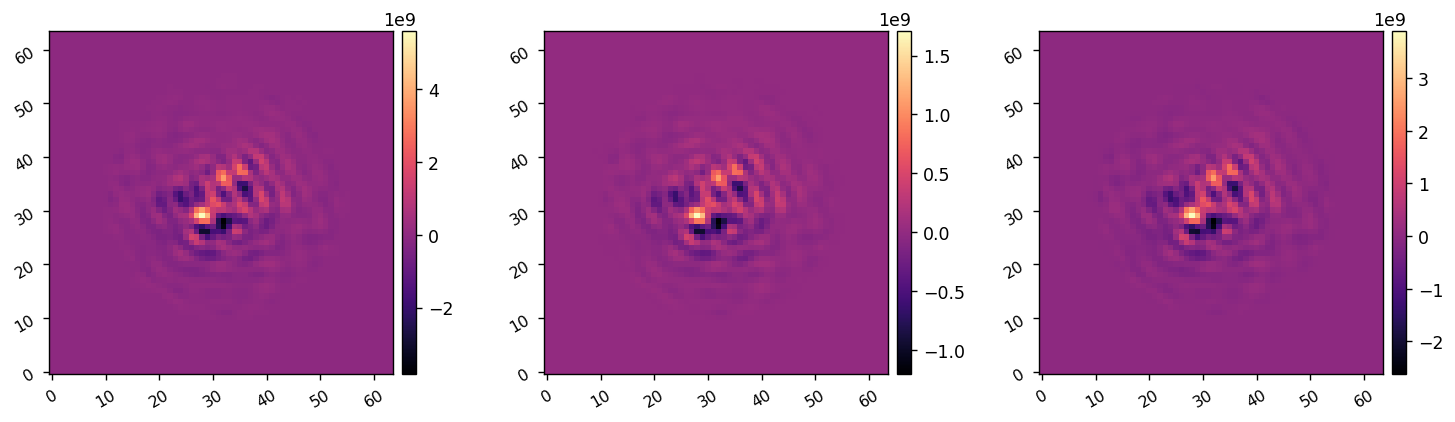

In [13]:
reload(wfsc.iefc)

probe_amp = 3e-8
calib_amp = 5e-9

c.texp = 1
differential_images, single_images = wfsc.iefc_1dm.take_measurement(c, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(2, c.npsf, c.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

# Calibrate IEFC (or load in previous calibration data)

In [17]:
reload(wfsc.iefc_1dm)
response_matrix, response_cube = wfsc.iefc_1dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, fourier_modes, 
                                                         return_all=True)

Calibrating I-EFC...
	Calibrated mode 1 / 344 in 2.505s
	Calibrated mode 2 / 344 in 5.000s
	Calibrated mode 3 / 344 in 7.489s
	Calibrated mode 4 / 344 in 9.976s
	Calibrated mode 5 / 344 in 12.463s
	Calibrated mode 6 / 344 in 14.955s
	Calibrated mode 7 / 344 in 17.446s
	Calibrated mode 8 / 344 in 20.356s
	Calibrated mode 9 / 344 in 22.847s
	Calibrated mode 10 / 344 in 25.335s
	Calibrated mode 11 / 344 in 27.830s
	Calibrated mode 12 / 344 in 30.310s
	Calibrated mode 13 / 344 in 32.796s
	Calibrated mode 14 / 344 in 35.281s
	Calibrated mode 15 / 344 in 37.765s
	Calibrated mode 16 / 344 in 40.251s
	Calibrated mode 17 / 344 in 42.746s
	Calibrated mode 18 / 344 in 45.233s
	Calibrated mode 19 / 344 in 47.719s
	Calibrated mode 20 / 344 in 50.208s
	Calibrated mode 21 / 344 in 52.693s
	Calibrated mode 22 / 344 in 55.183s
	Calibrated mode 23 / 344 in 57.673s
	Calibrated mode 24 / 344 in 60.162s
	Calibrated mode 25 / 344 in 62.645s
	Calibrated mode 26 / 344 in 65.128s
	Calibrated mode 27 / 344 in 6

	Calibrated mode 215 / 344 in 530.917s
	Calibrated mode 216 / 344 in 533.377s
	Calibrated mode 217 / 344 in 535.838s
	Calibrated mode 218 / 344 in 538.305s
	Calibrated mode 219 / 344 in 540.769s
	Calibrated mode 220 / 344 in 543.220s
	Calibrated mode 221 / 344 in 545.676s
	Calibrated mode 222 / 344 in 548.125s
	Calibrated mode 223 / 344 in 550.579s
	Calibrated mode 224 / 344 in 553.038s
	Calibrated mode 225 / 344 in 555.500s
	Calibrated mode 226 / 344 in 557.953s
	Calibrated mode 227 / 344 in 560.414s
	Calibrated mode 228 / 344 in 562.874s
	Calibrated mode 229 / 344 in 565.330s
	Calibrated mode 230 / 344 in 567.783s
	Calibrated mode 231 / 344 in 570.436s
	Calibrated mode 232 / 344 in 572.884s
	Calibrated mode 233 / 344 in 575.329s
	Calibrated mode 234 / 344 in 577.776s
	Calibrated mode 235 / 344 in 580.226s
	Calibrated mode 236 / 344 in 582.681s
	Calibrated mode 237 / 344 in 585.127s
	Calibrated mode 238 / 344 in 587.578s
	Calibrated mode 239 / 344 in 590.029s
	Calibrated mode 240 / 34

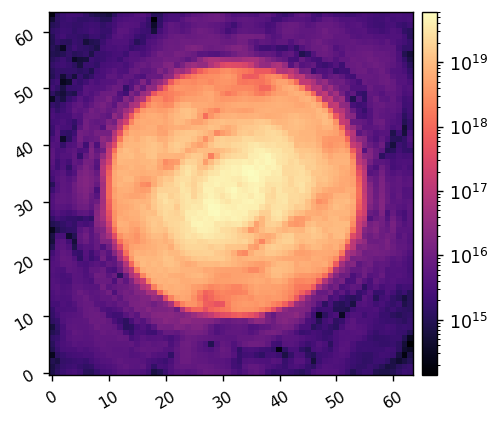

In [20]:
response_sum = xp.sum(abs(response_cube), axis=(0,1))
wfsc.imshow1(response_sum.reshape(npsf, npsf), lognorm=True)

In [22]:
import misc_funs as misc

iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_response_matrix_20230424.fits', response_matrix.get())
misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_response_cube_20230424.fits', response_cube.get())

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_iefc_response_matrix_20230424.fits
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_iefc_response_cube_20230424.fits


# Create control matrix

Running I-EFC...
	Closed-loop iteration 0 / 20


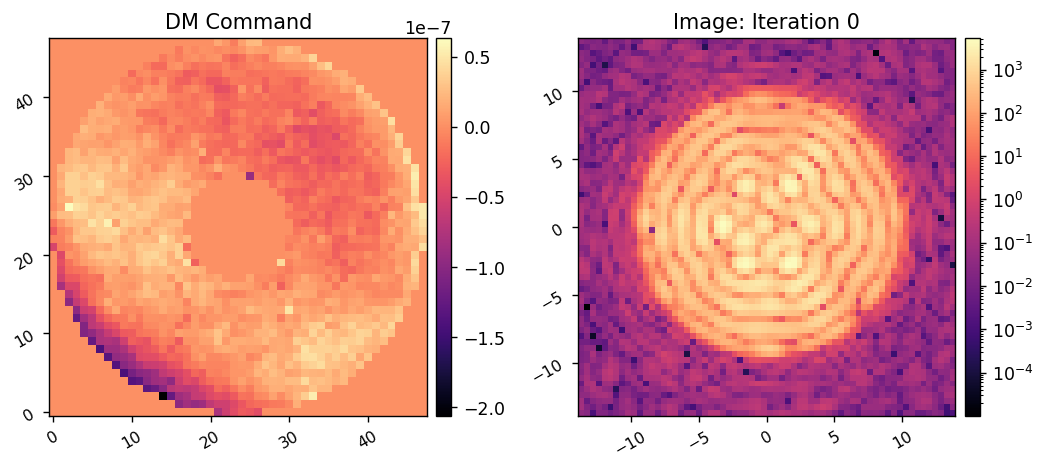

	Closed-loop iteration 1 / 20


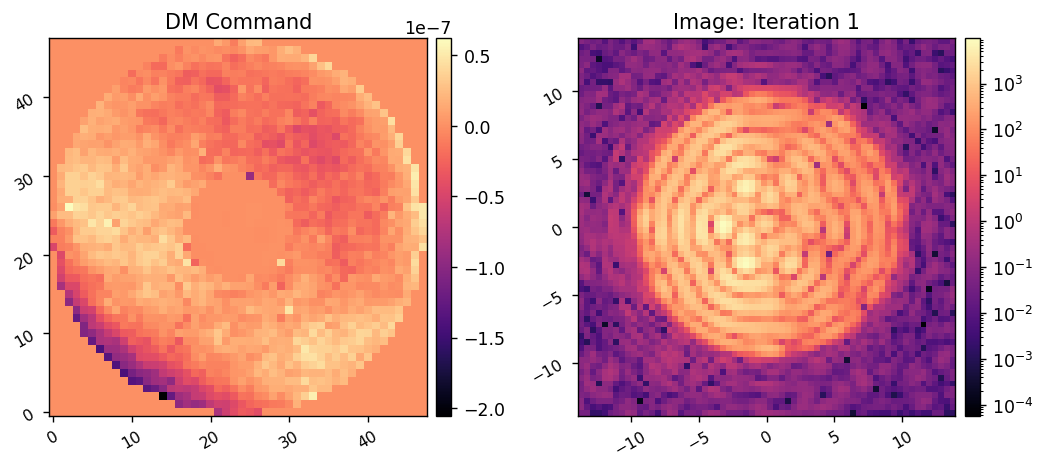

	Closed-loop iteration 2 / 20


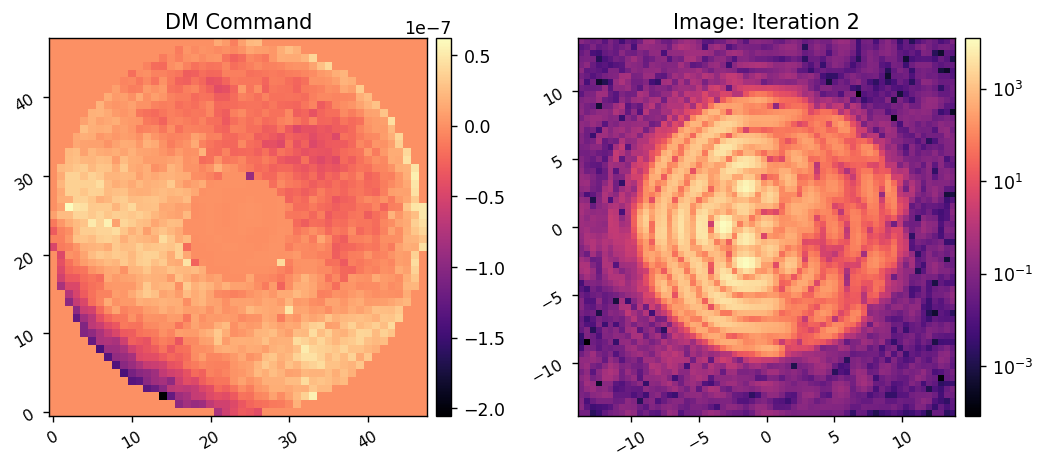

	Closed-loop iteration 3 / 20


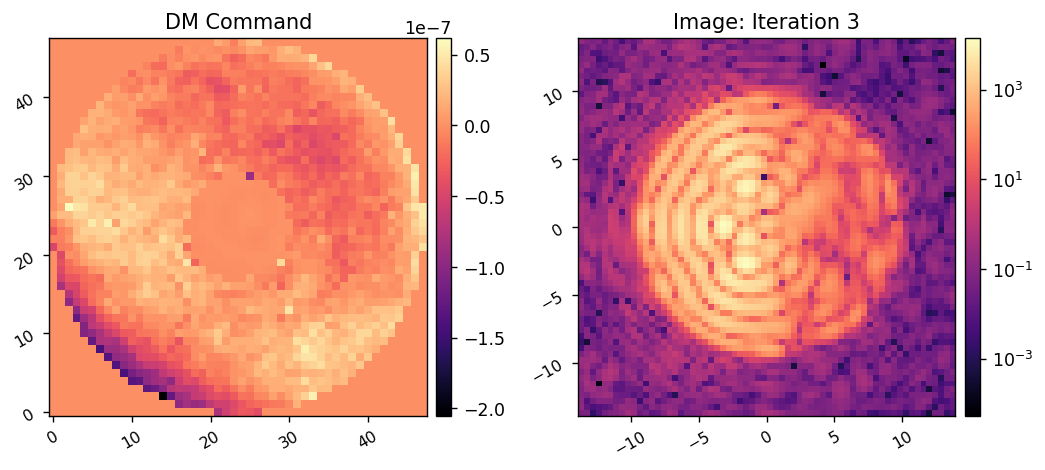

	Closed-loop iteration 4 / 20


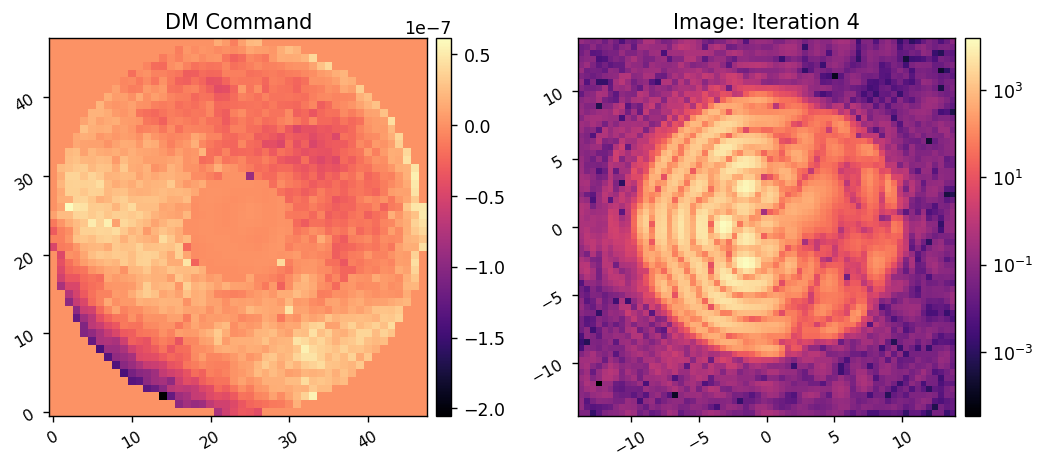

	Closed-loop iteration 5 / 20


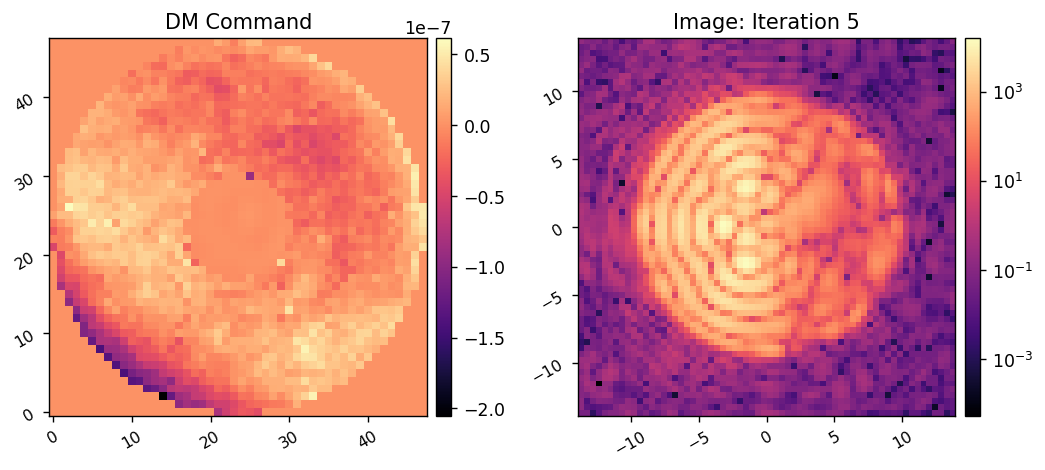

	Closed-loop iteration 6 / 20


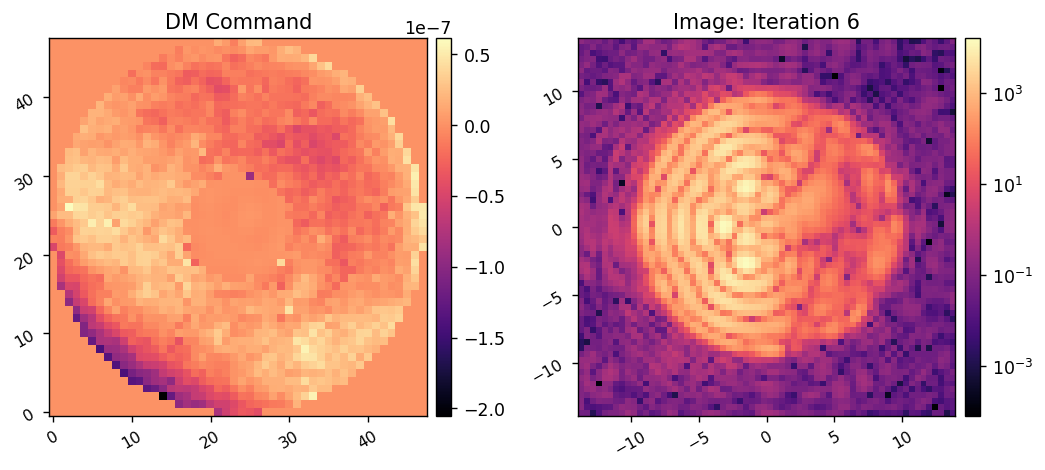

	Closed-loop iteration 7 / 20


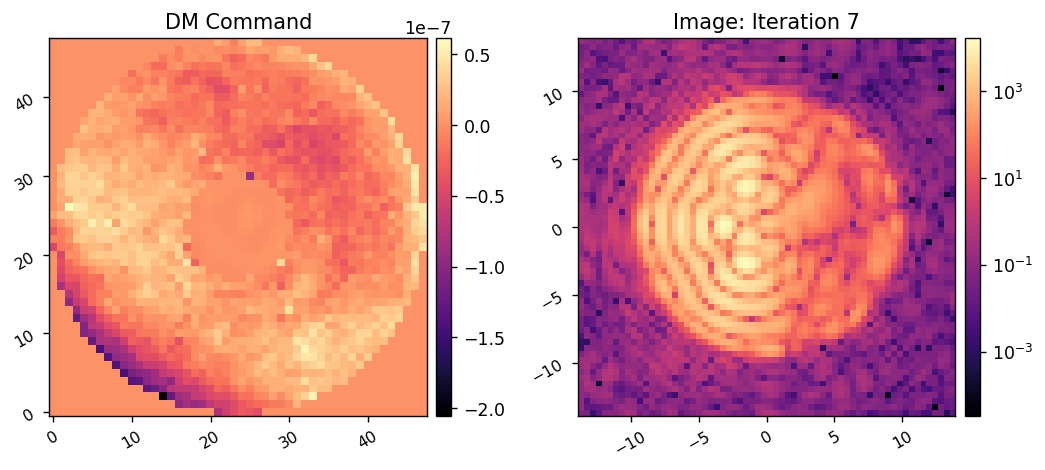

	Closed-loop iteration 8 / 20


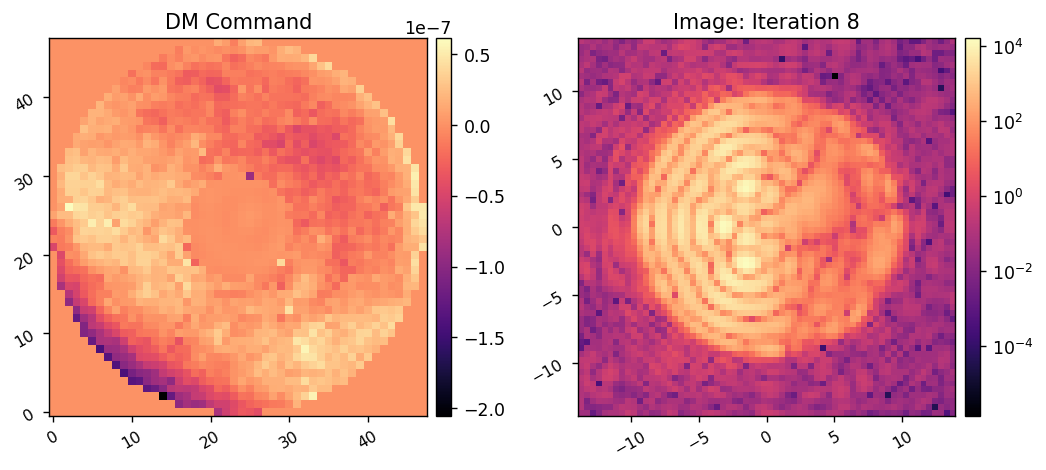

	Closed-loop iteration 9 / 20


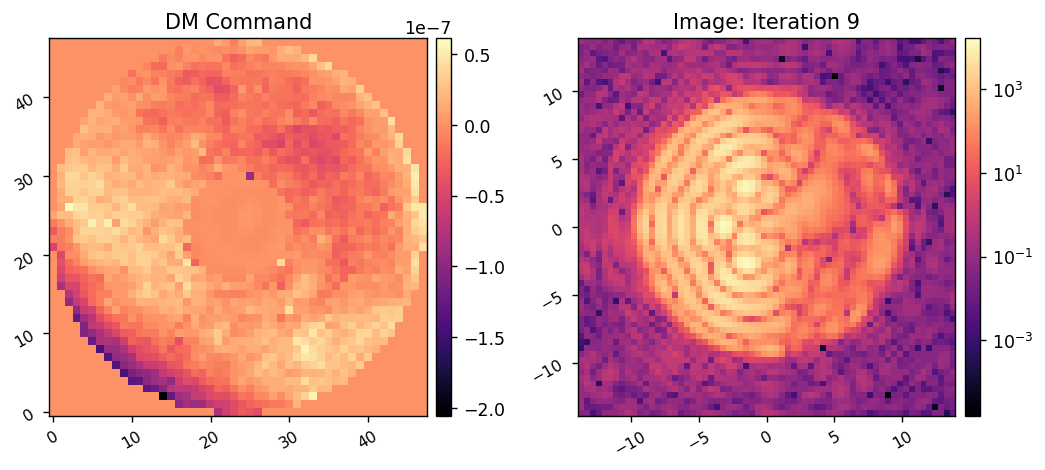

	Closed-loop iteration 10 / 20


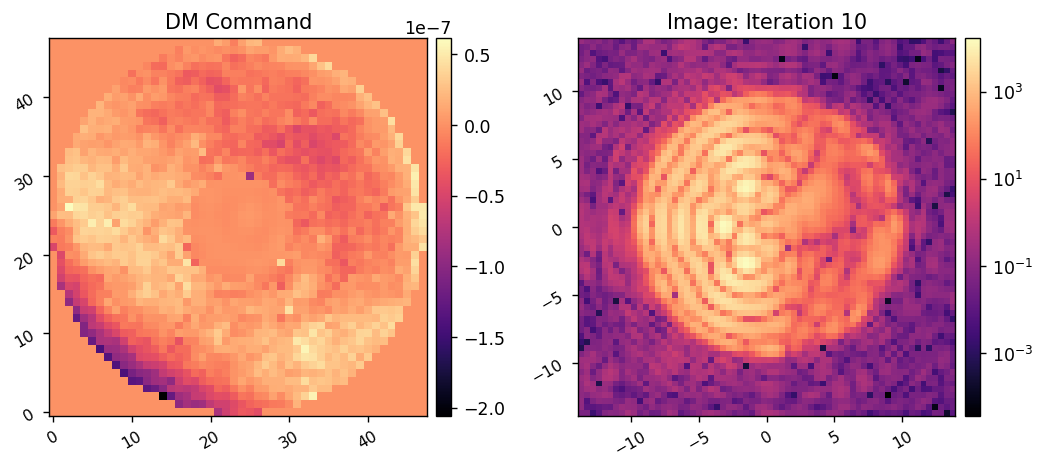

	Closed-loop iteration 11 / 20


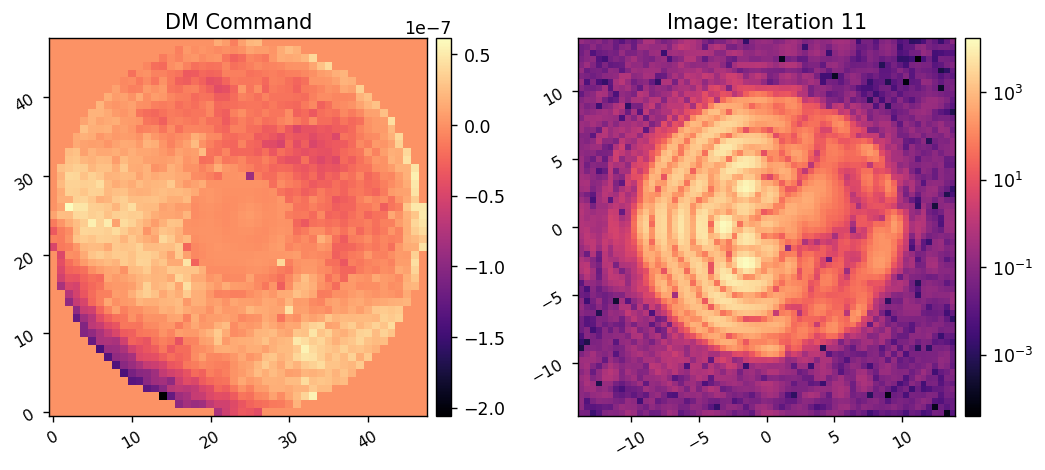

	Closed-loop iteration 12 / 20


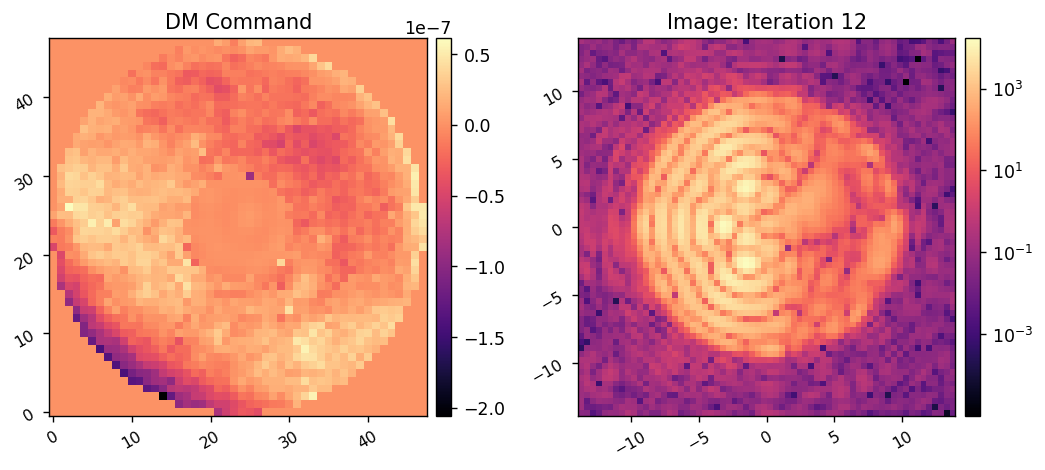

	Closed-loop iteration 13 / 20


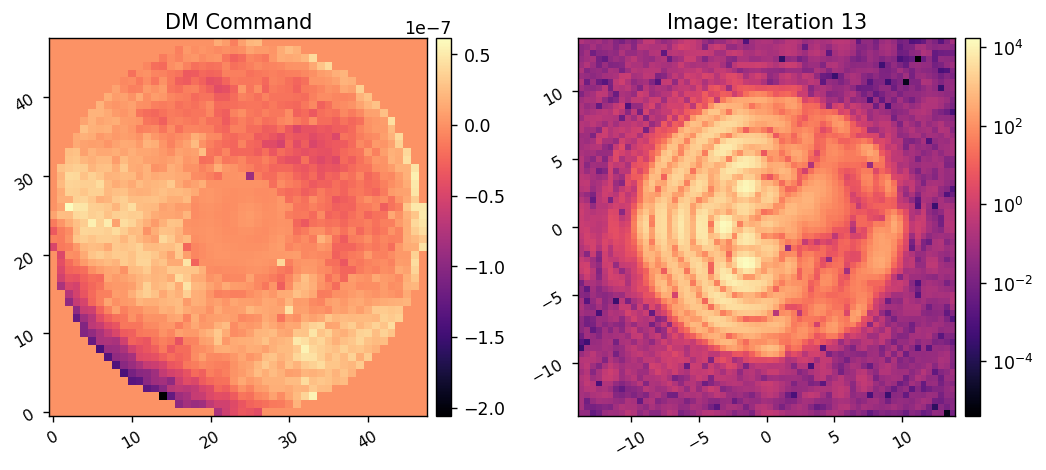

	Closed-loop iteration 14 / 20


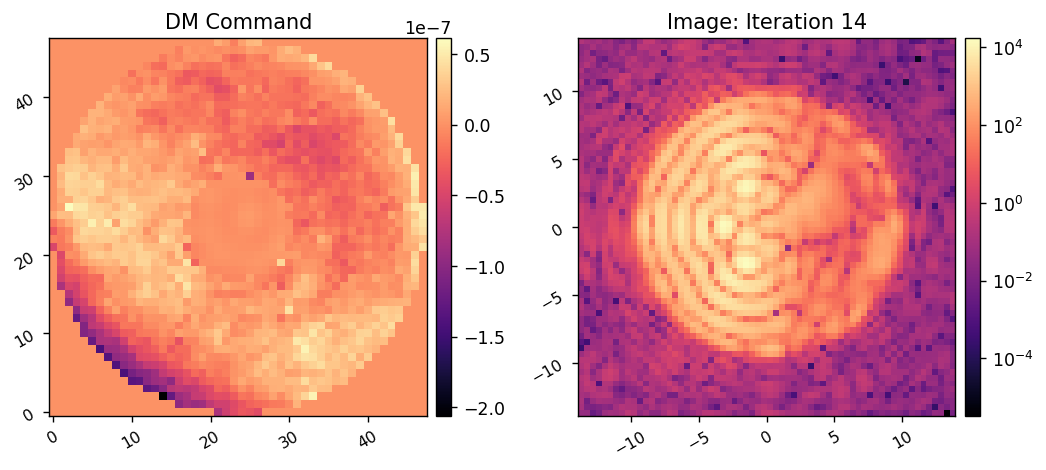

	Closed-loop iteration 15 / 20


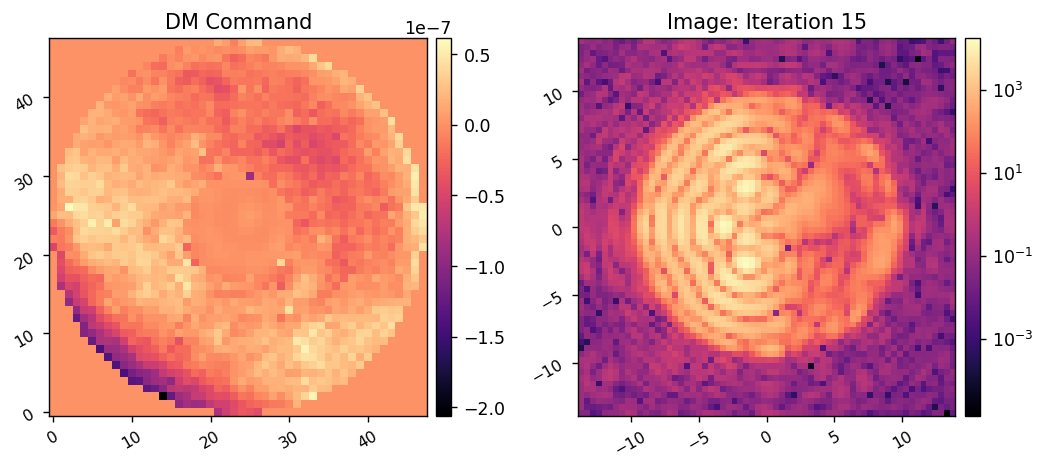

	Closed-loop iteration 16 / 20


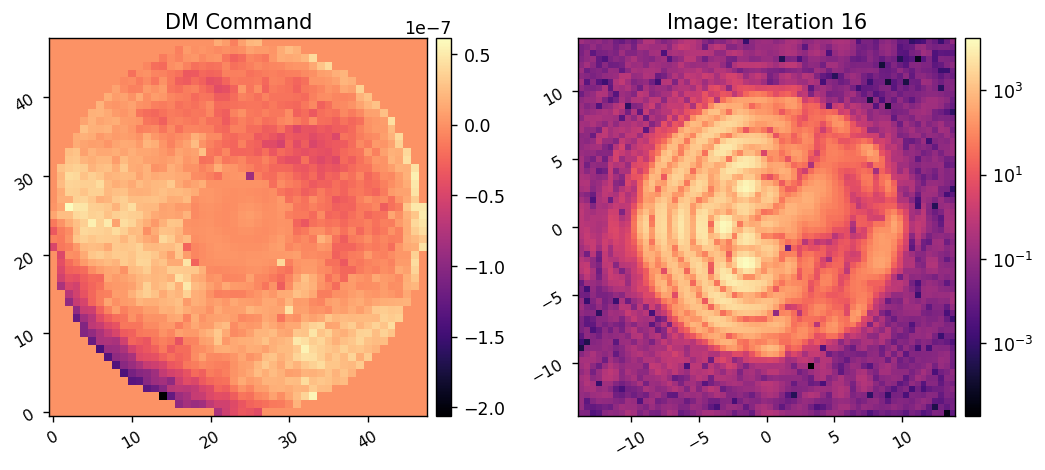

	Closed-loop iteration 17 / 20


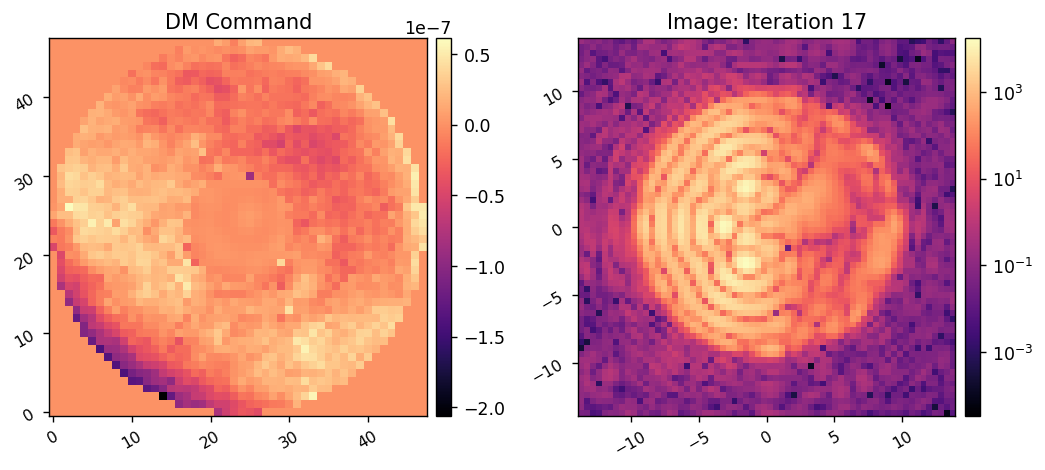

	Closed-loop iteration 18 / 20


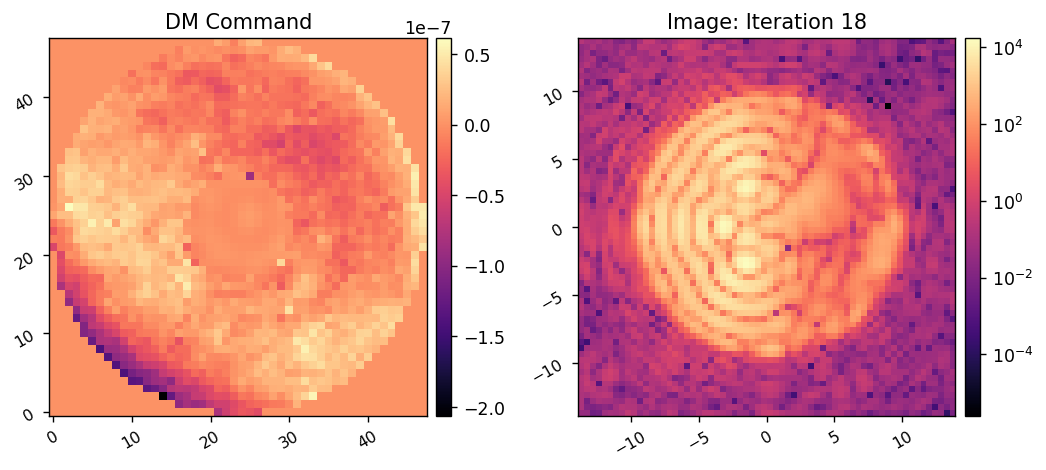

	Closed-loop iteration 19 / 20


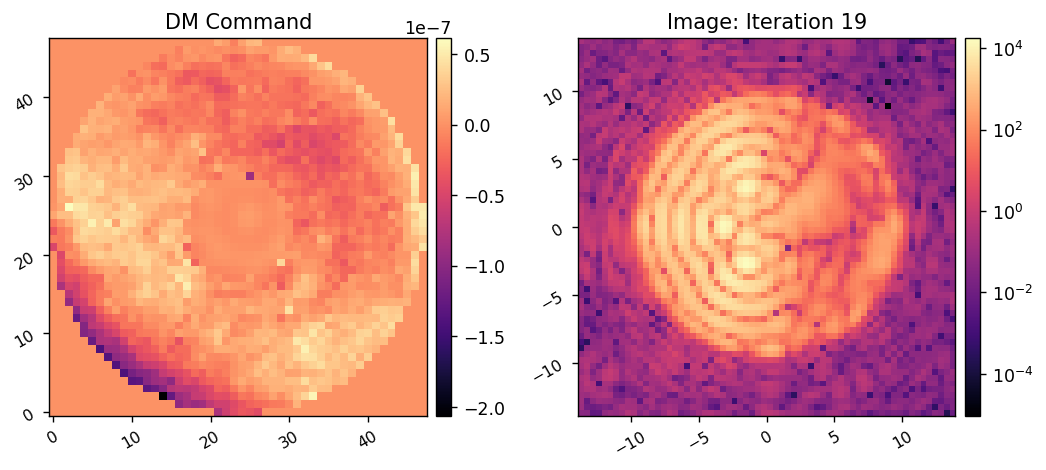

	Closed-loop iteration 20 / 20


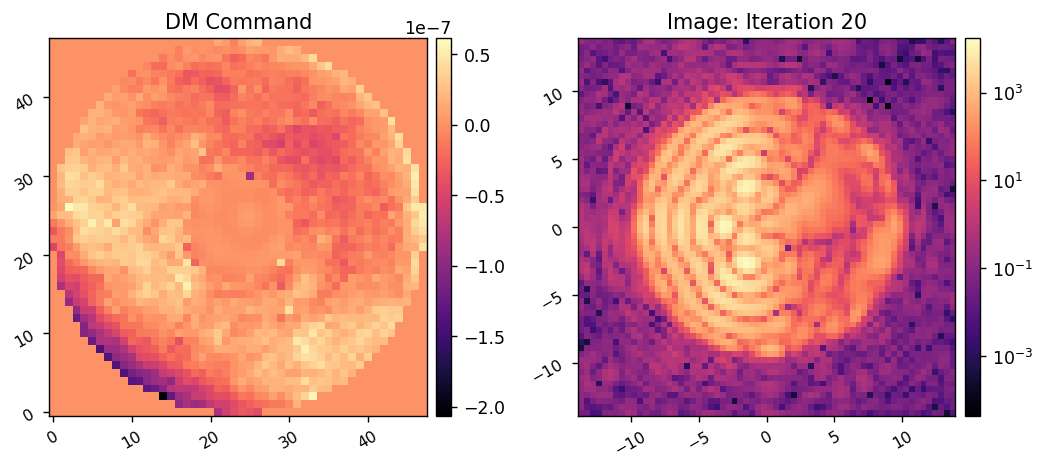

I-EFC loop completed in 41.830s.


In [30]:
reload(wfsc.iefc_1dm)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

reg_cond = 1e-2

cm_tik = wfsc.utils.TikhonovInverse(response_matrix, rcond=reg_cond)
Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask])))
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_cond)

images, dm_commands_1 = wfsc.iefc_1dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          fourier_modes,
                                          control_mask.ravel(), 
                                          num_iterations=20, 
                                          loop_gain=0.5, leakage=0.0,
                                          display_all=True,
                                         )

Running I-EFC...
	Closed-loop iteration 0 / 20


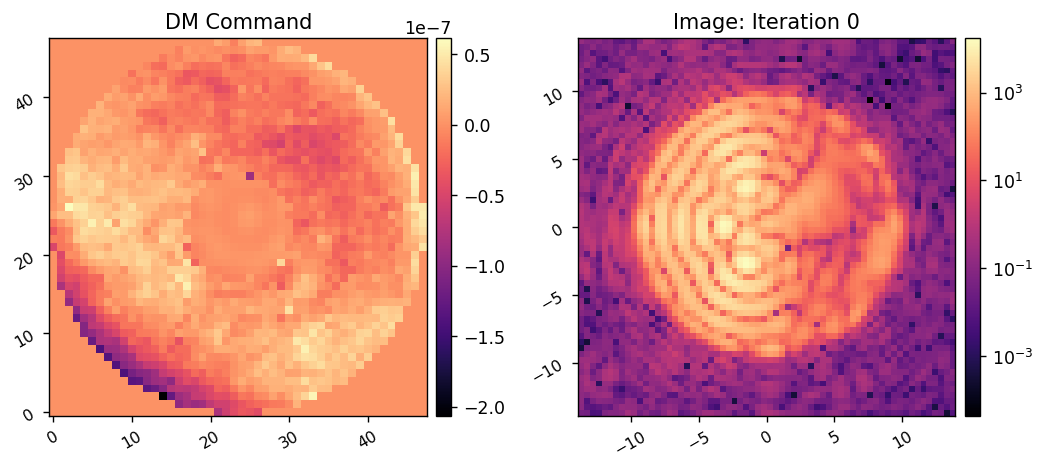

	Closed-loop iteration 1 / 20


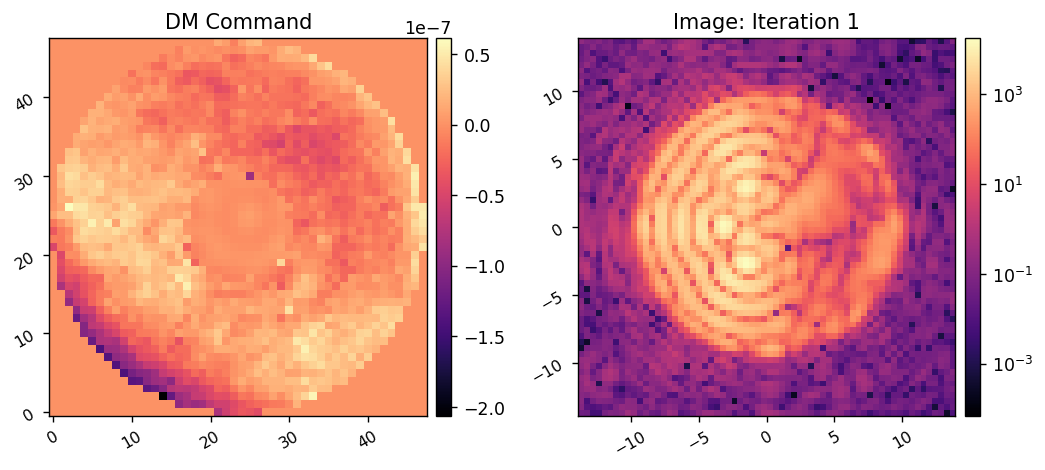

	Closed-loop iteration 2 / 20


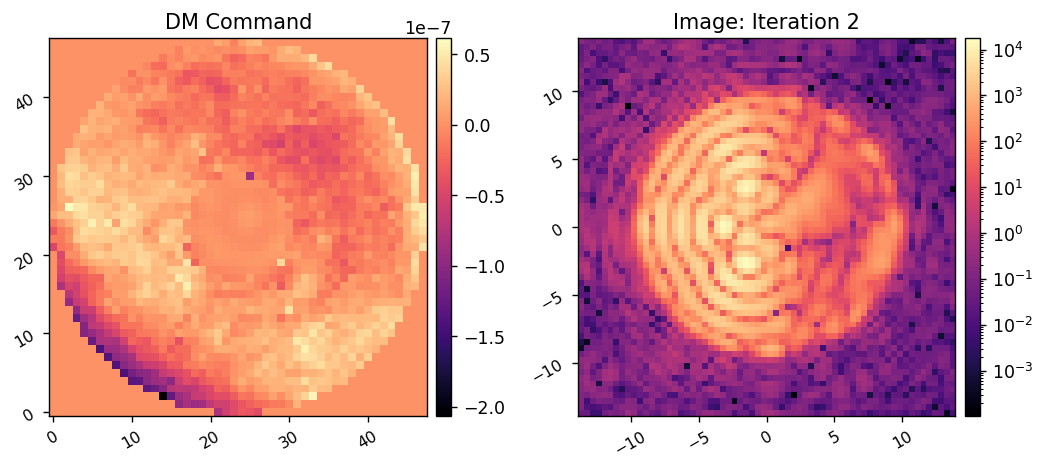

	Closed-loop iteration 3 / 20


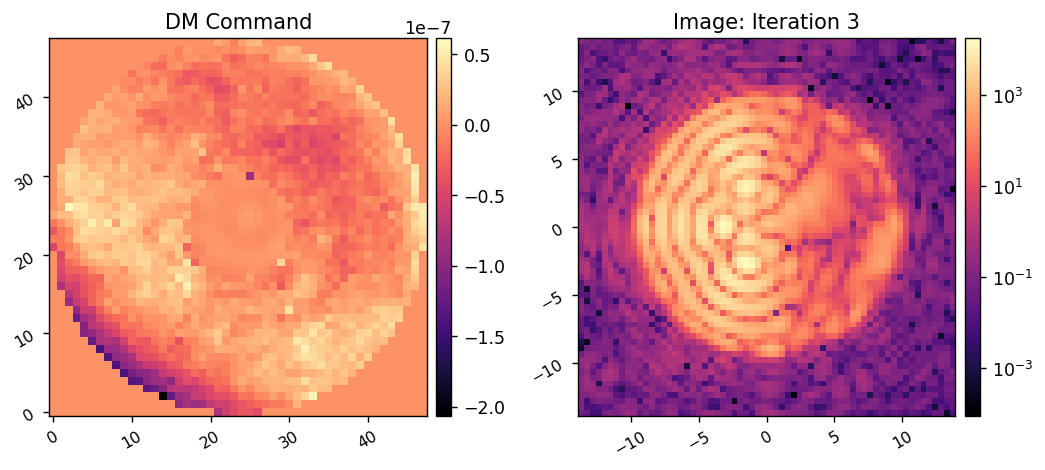

	Closed-loop iteration 4 / 20


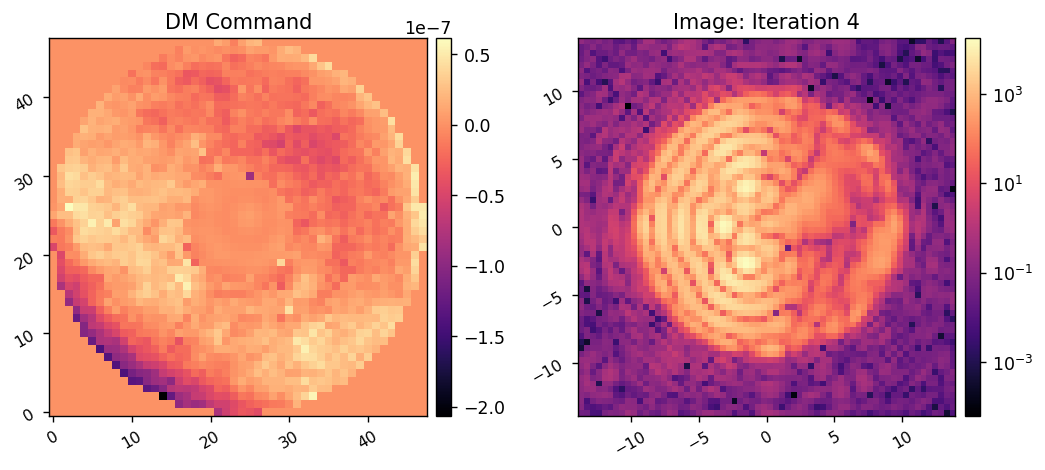

	Closed-loop iteration 5 / 20


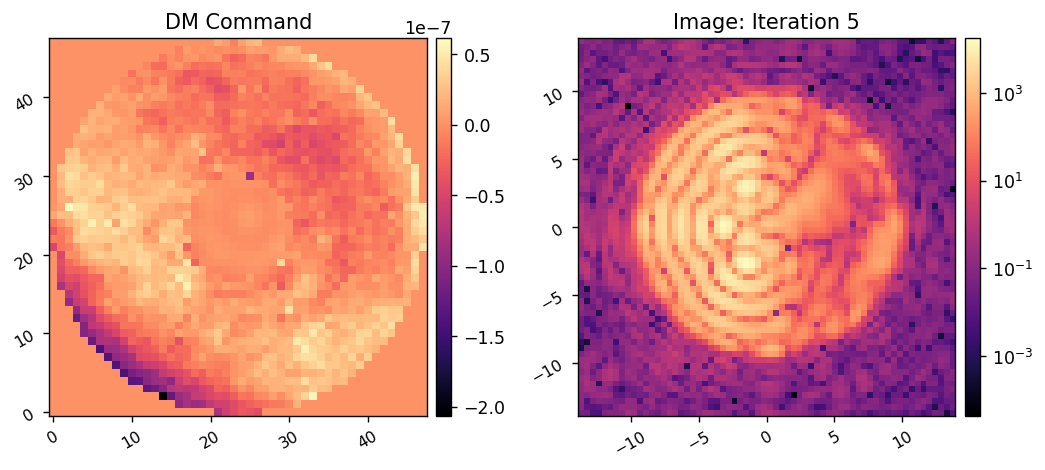

	Closed-loop iteration 6 / 20


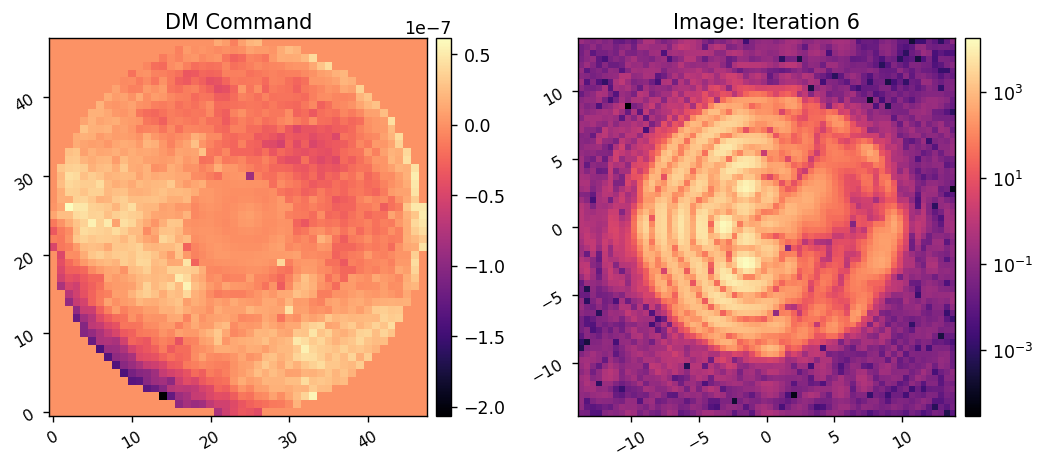

	Closed-loop iteration 7 / 20


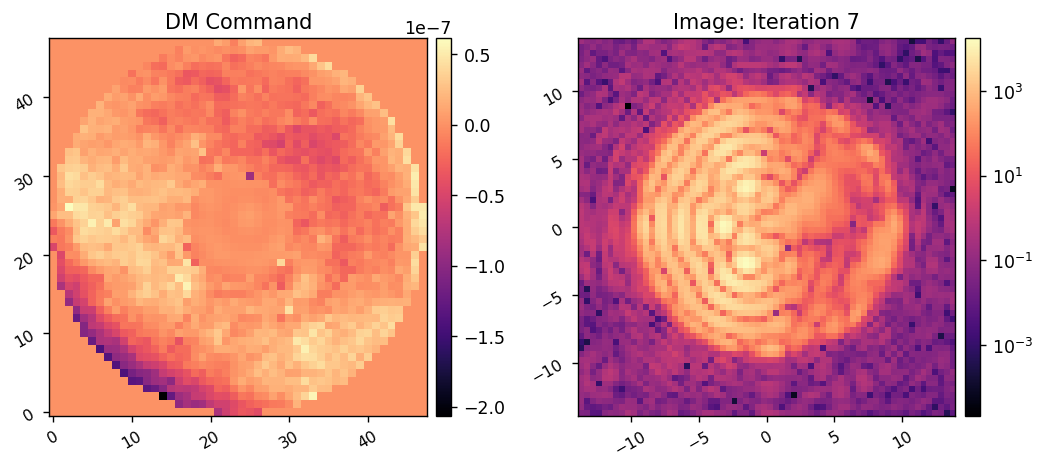

	Closed-loop iteration 8 / 20


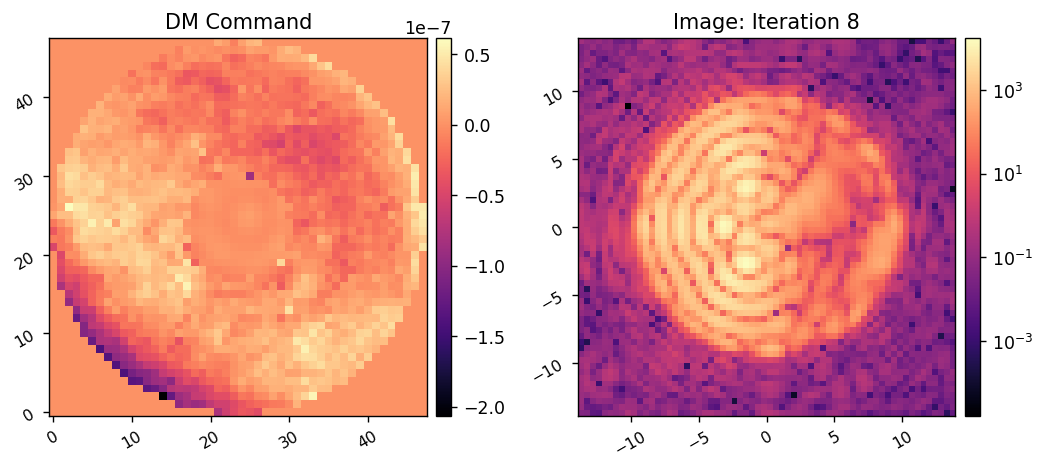

	Closed-loop iteration 9 / 20


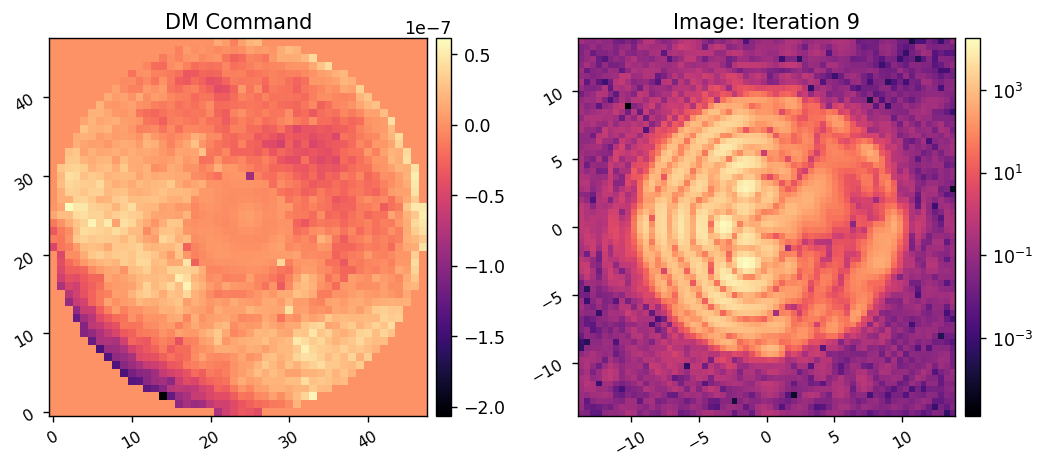

	Closed-loop iteration 10 / 20


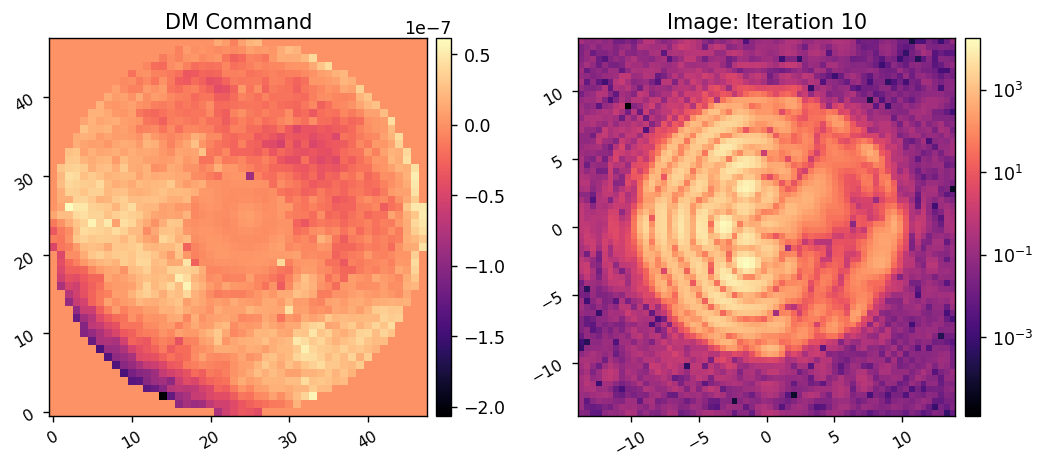

	Closed-loop iteration 11 / 20


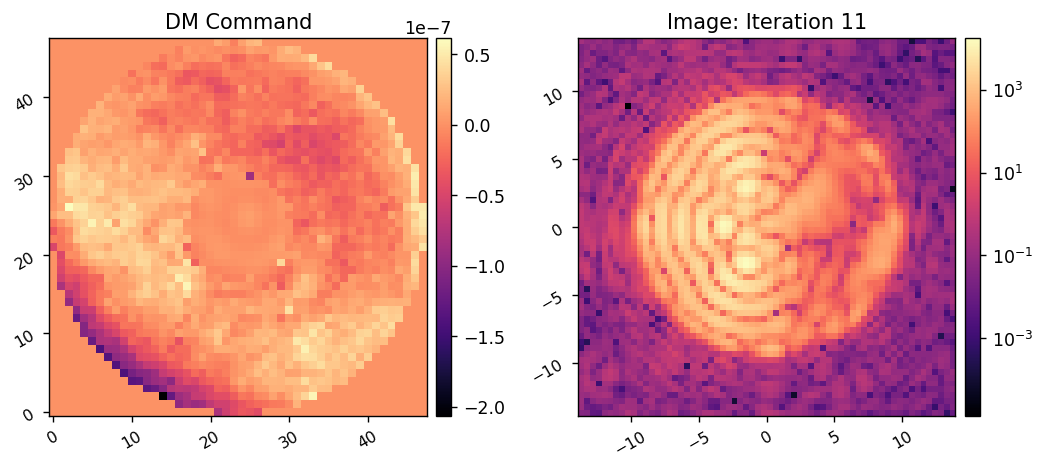

	Closed-loop iteration 12 / 20


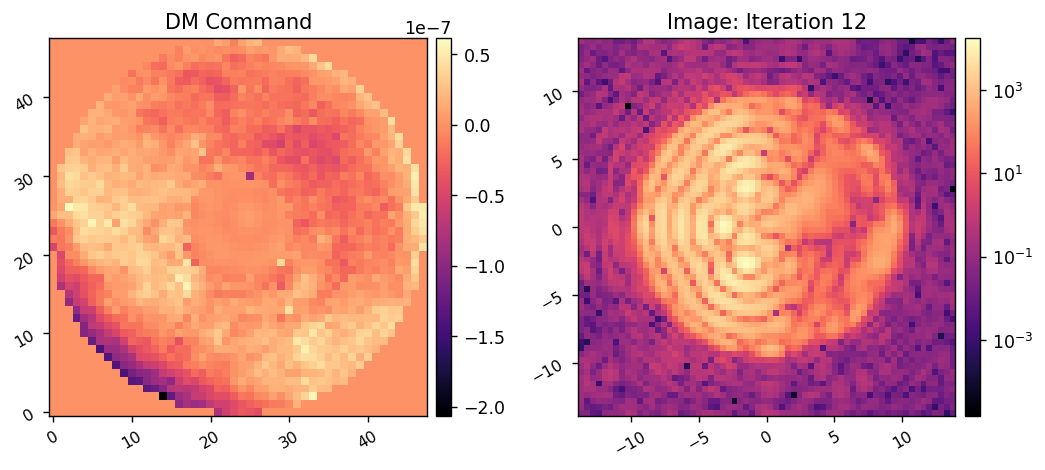

	Closed-loop iteration 13 / 20


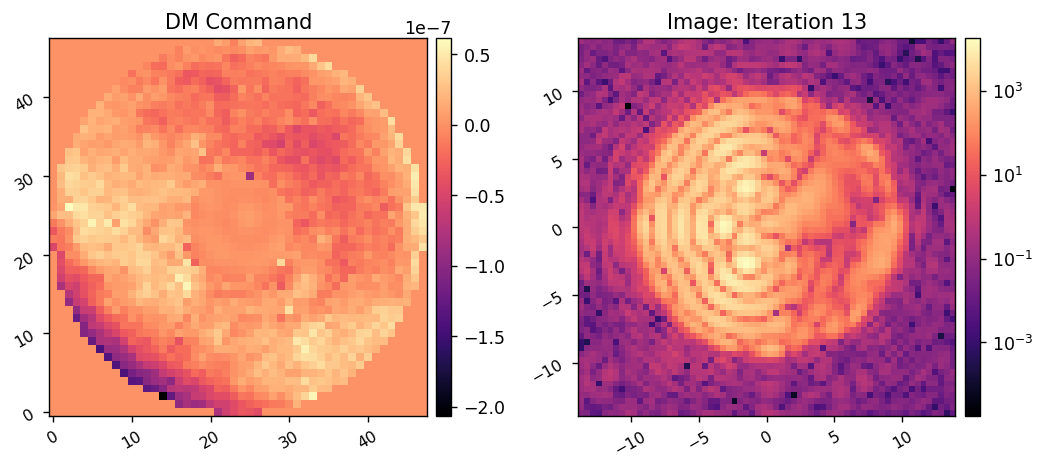

	Closed-loop iteration 14 / 20


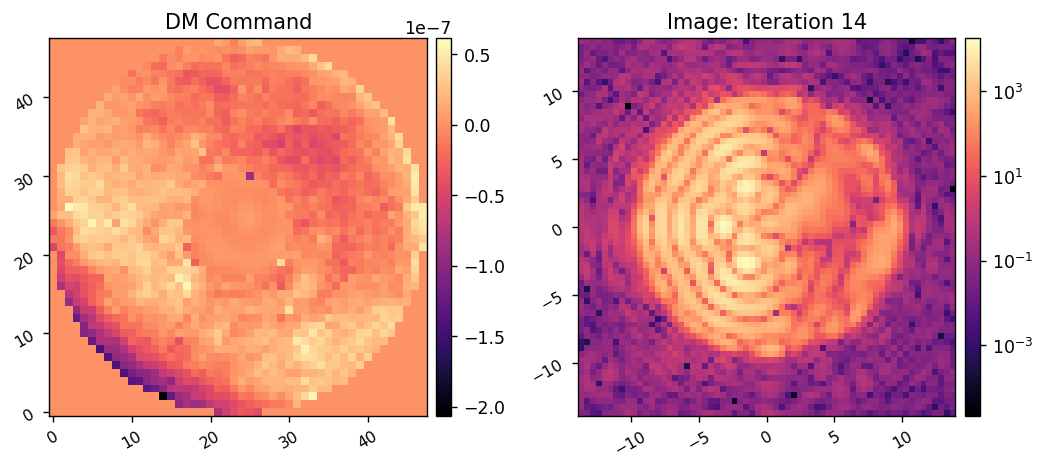

	Closed-loop iteration 15 / 20


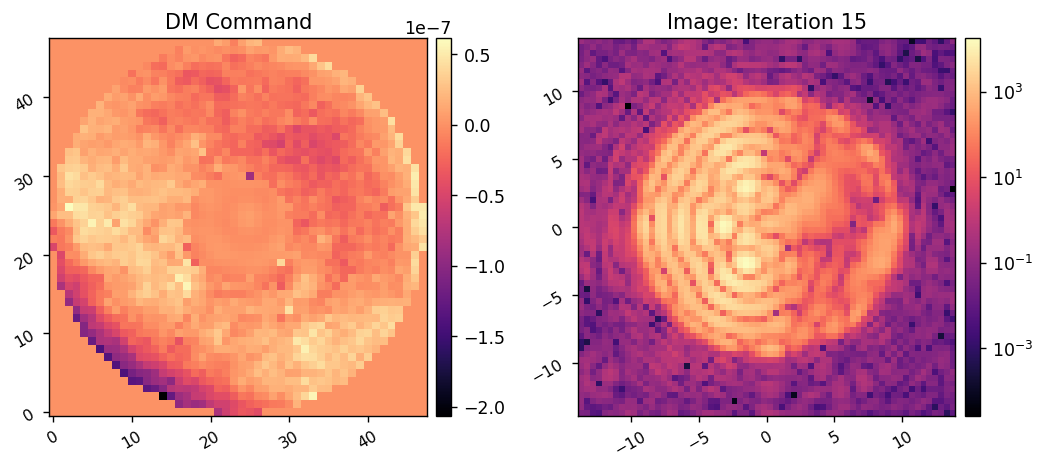

	Closed-loop iteration 16 / 20


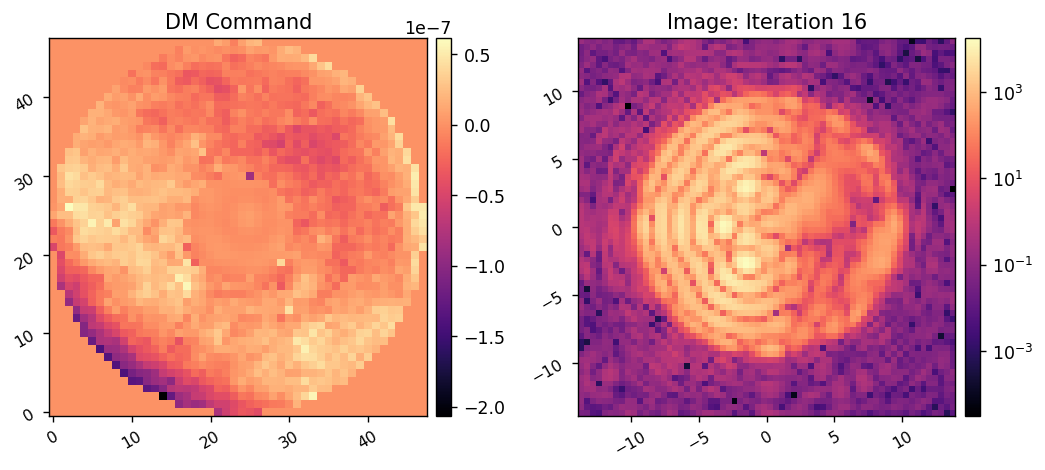

	Closed-loop iteration 17 / 20


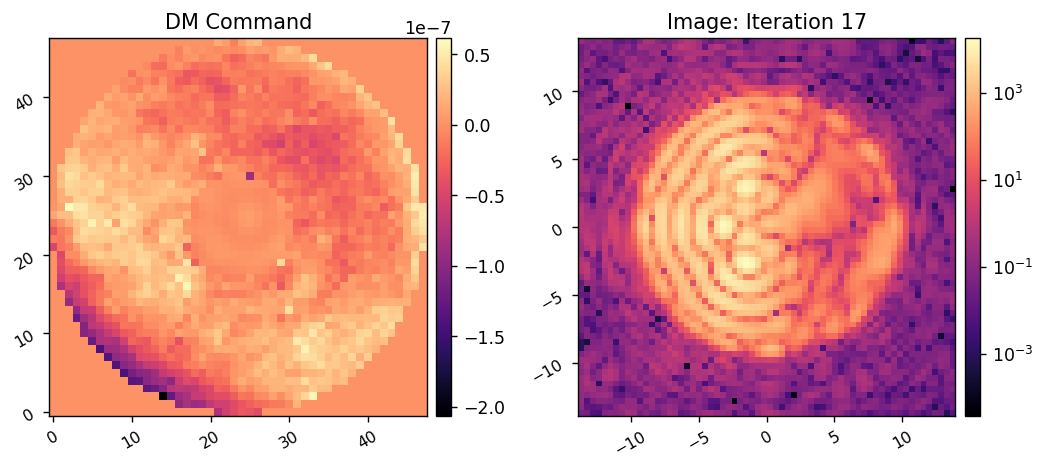

	Closed-loop iteration 18 / 20


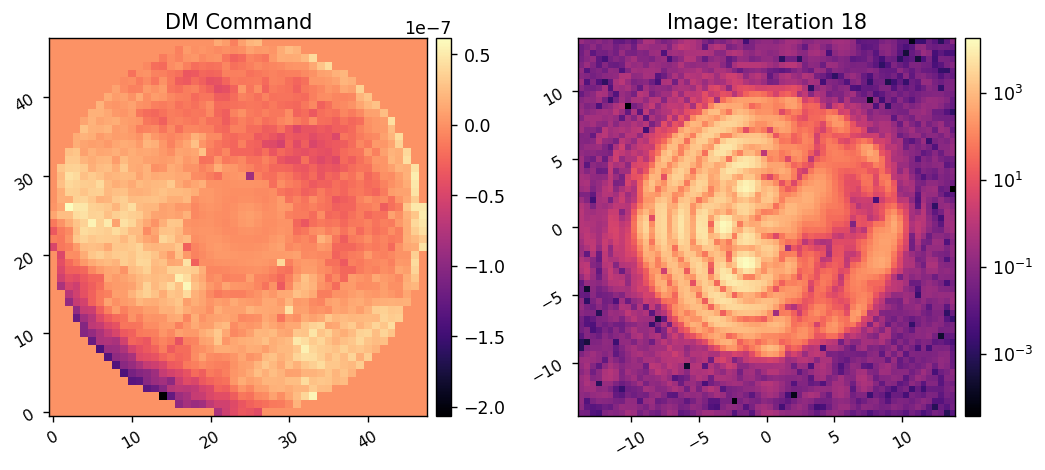

	Closed-loop iteration 19 / 20


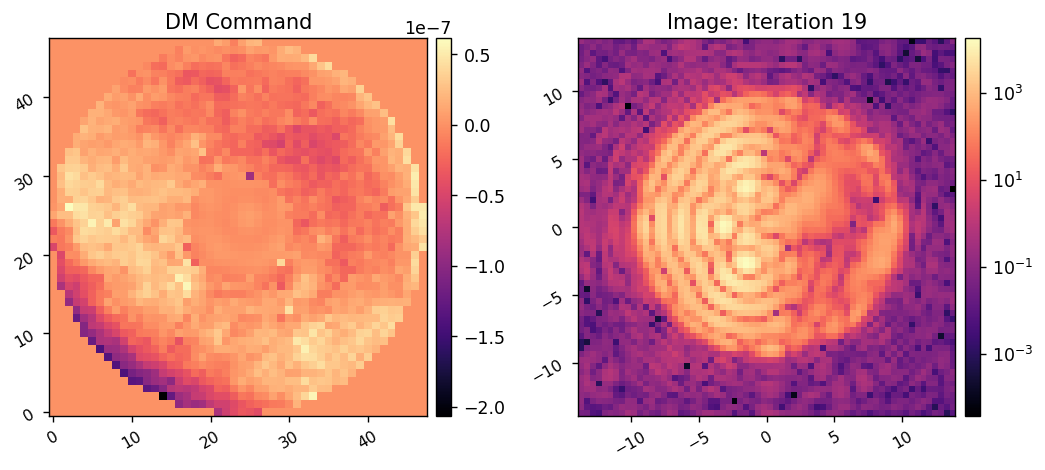

	Closed-loop iteration 20 / 20


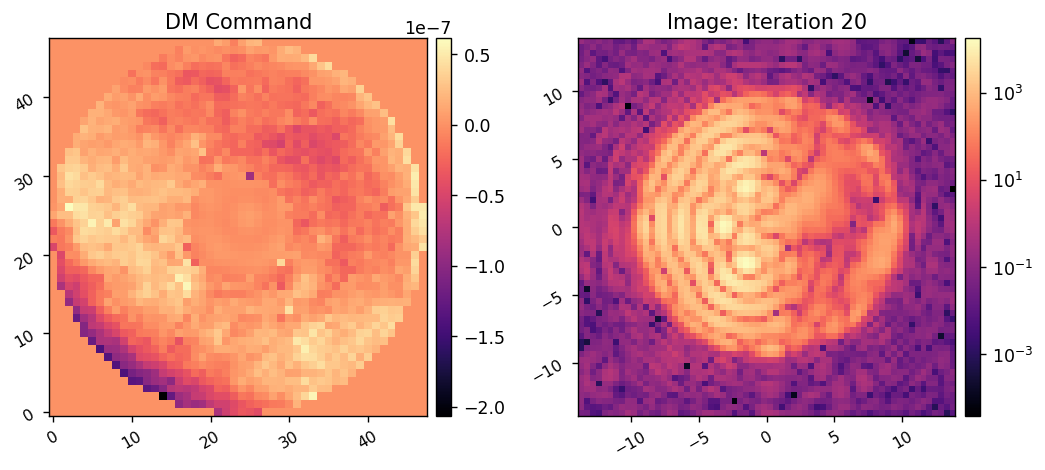

I-EFC loop completed in 40.913s.


In [31]:
reload(wfsc.iefc_1dm)

reg_cond = 1e-1

cm_tik = wfsc.utils.TikhonovInverse(response_matrix, rcond=reg_cond)
Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask])))
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_cond)

images, dm_commands_2 = wfsc.iefc_1dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          fourier_modes,
                                          control_mask.ravel(), 
                                          num_iterations=20, 
                                          loop_gain=0.5, leakage=0.0,
                                          display_all=True,
                                         )

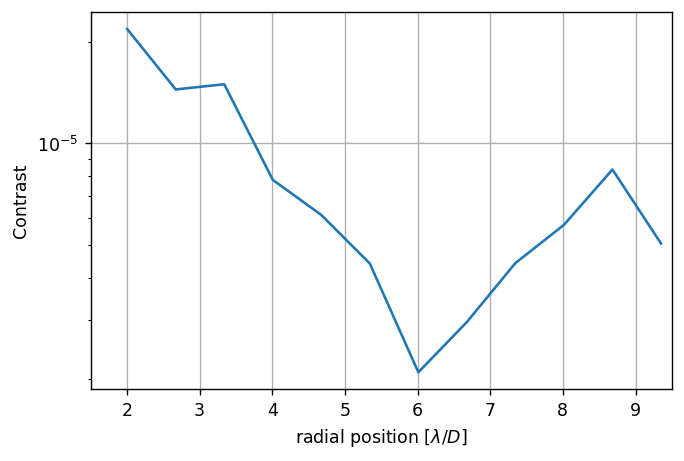

In [71]:
import matplotlib.pyplot as plt
reload(wfsc.utils)

wfsc.utils.plot_radial_contrast(images[-1]/max_ref, control_mask, c.psf_pixelscale_lamD, nbins=30,
                                xlims=(1.5,9.5))